In [2]:
!pip install torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 MB 47.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 43.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 51.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12


In [10]:
!pip install gdown

In [4]:
import torch
from torchvision.datasets import CelebA
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [6]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),       # Resize all images to 64x64
    transforms.ToTensor(),             # Convert to tensor and scale pixel values to [0,1]
])


In [20]:
celeba_dataset = CelebA(
    root='/Users/alarshtiwari/Downloads/data',
    split='train',
    target_type='attr',
    transform=transform,
    download=False
)

RuntimeError: Dataset not found or corrupted. You can use download=True to download it

In [22]:
import os

base = "/Users/alarshtiwari/Downloads/data/celeba"

print("Images exist?", os.path.exists(os.path.join(base, "img_align_celeba/000001.jpg")))
print("Labels exist?", os.path.exists(os.path.join(base, "list_attr_celeba.txt")))
print("Split file exists?", os.path.exists(os.path.join(base, "list_eval_partition.txt")))


Images exist? True
Labels exist? True
Split file exists? True


In [24]:
import os
os.listdir("/Users/alarshtiwari/Downloads/data/celeba")


['list_attr_celeba.txt',
 '.DS_Store',
 'list_eval_partition.txt',
 'img_align_celeba']

In [26]:
from torchvision.datasets import CelebA
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

celeba_dataset = CelebA(
    root='/Users/alarshtiwari/Downloads/data',
    split='train',
    target_type='attr',
    transform=transform,
    download=False
)

print(f"✅ Loaded CelebA with {len(celeba_dataset)} training images")


RuntimeError: Dataset not found or corrupted. You can use download=True to download it

In [30]:
import os

base = "/Users/alarshtiwari/Downloads/data/celeba"

# Check image count
image_folder = os.path.join(base, "img_align_celeba")
image_files = os.listdir(image_folder)
print("🖼️ Total images found:", len(image_files))
print("Example image file:", image_files[0] if image_files else "None")

# Check for required .txt files
for fname in ["list_attr_celeba.txt", "list_eval_partition.txt"]:
    fpath = os.path.join(base, fname)
    print(f"\n📄 Checking {fname}")
    if os.path.exists(fpath):
        with open(fpath) as f:
            print("✔️ Exists. First line:", f.readline().strip())
    else:
        print("❌ Missing!")

# Final test: image + label match
print("\n✅ Checking if 000001.jpg exists:", os.path.exists(os.path.join(image_folder, "000001.jpg")))


🖼️ Total images found: 202599
Example image file: 052628.jpg

📄 Checking list_attr_celeba.txt
✔️ Exists. First line: 202599

📄 Checking list_eval_partition.txt
✔️ Exists. First line: 000001.jpg 0

✅ Checking if 000001.jpg exists: True


In [2]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torch

class CustomCelebADataset(Dataset):
    def __init__(self, root, split='train', transform=None):
        self.root = root
        self.transform = transform
        
        # Paths to metadata files
        attr_path = os.path.join(root, 'celeba', 'list_attr_celeba.txt')
        split_path = os.path.join(root, 'celeba', 'list_eval_partition.txt')
        img_folder = os.path.join(root, 'celeba', 'img_align_celeba')

        # Load labels
        with open(attr_path) as f:
            lines = f.readlines()
            header = lines[1].strip().split()
            data = [line.strip().split() for line in lines[2:]]
        
        self.attr_names = header
        df_attr = pd.DataFrame(data)
        df_attr.columns = ['filename'] + header
        df_attr[header] = df_attr[header].astype(int)
        df_attr[header] = (df_attr[header] == 1).astype(int)  # convert -1 to 0

        # Load split info
        df_split = pd.read_csv(split_path, delim_whitespace=True, header=None, names=['filename', 'split'])

        # Merge and filter by split
        df = pd.merge(df_attr, df_split, on='filename')
        split_map = {'train': 0, 'valid': 1, 'test': 2}
        self.df = df[df['split'] == split_map[split]].reset_index(drop=True)

        self.img_folder = img_folder

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_folder, row['filename'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        labels = torch.tensor(row[self.attr_names].values.astype('float32'))
        return image, labels


In [4]:
from torchvision import transforms
from torch.utils.data import DataLoader

# Transform for classical models (flattened)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # flatten to 12288-dim
])

dataset = CustomCelebADataset(
    root='/Users/alarshtiwari/Downloads/data',
    split='train',
    transform=transform
)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


/var/folders/f2/jlpgwxs145s1glttx7dg5vrw0000gn/T/ipykernel_19258/3961479262.py:30: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_split = pd.read_csv(split_path, delim_whitespace=True, header=None, names=['filename', 'split'])


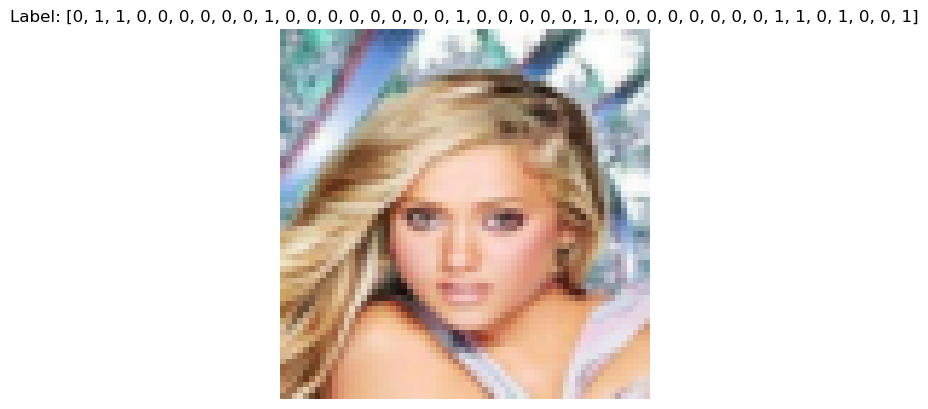

In [5]:
import matplotlib.pyplot as plt

# Get one batch
images, labels = next(iter(dataloader))

# For flattened input (Logistic/LDA), reshape for viewing
img = images[0].view(3, 64, 64).permute(1, 2, 0)  # HWC format
plt.imshow(img)
plt.axis('off')
plt.title(f"Label: {labels[0].int().tolist()}")
plt.show()


In [6]:
#Standardization
import numpy as np
from sklearn.preprocessing import StandardScaler

# Step 1: Extract all (image, label) pairs into full arrays
X_list = []
Y_list = []

for img, label in dataset:
    X_list.append(img.numpy())        # already flattened by transform
    Y_list.append(label.numpy())      # 40-dim binary vector

X = np.stack(X_list)  # shape: (n_samples, 12288)
Y = np.stack(Y_list)  # shape: (n_samples, 40)

print("Shapes - X:", X.shape, "Y:", Y.shape)

# Step 2: Standardize features (mean 0, std 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Standardization complete. Mean:", np.mean(X_scaled), "Std:", np.std(X_scaled))


Shapes - X: (162770, 12288) Y: (162770, 40)
Standardization complete. Mean: 2.7285991e-09 Std: 1.0000033


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Target label: "Smiling" = column index 31
y_smile = Y[:, 31]

# Train the logistic regression model
#clf = LogisticRegression(max_iter=1000)
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    max_iter=300,        # Lower the cap
    solver='saga',       # Fast for high-dimensional sparse data
    penalty='l2',        # Default
    tol=1e-3,            # Looser convergence threshold
    verbose=1            # See actual progress
)

clf.fit(X_scaled, y_smile)

# Predict on training data (you'll do validation later)
y_pred = clf.predict(X_scaled)

# Evaluate
print("Accuracy:", accuracy_score(y_smile, y_pred))
print("F1 Score:", f1_score(y_smile, y_pred))
print("\nClassification Report:")
print(classification_report(y_smile, y_pred))


convergence after 193 epochs took 1465 seconds
Accuracy: 0.9172697671561099
F1 Score: 0.9128470649148922

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92     84690
         1.0       0.92      0.90      0.91     78080

    accuracy                           0.92    162770
   macro avg       0.92      0.92      0.92    162770
weighted avg       0.92      0.92      0.92    162770



In [8]:
#Validation
val_dataset = CustomCelebADataset(
    root='/Users/alarshtiwari/Downloads/data',
    split='valid',
    transform=transform
)
X_val = []
Y_val = []

for img, label in val_dataset:
    X_val.append(img.numpy())
    Y_val.append(label.numpy())

X_val = np.stack(X_val)
Y_val = np.stack(Y_val)

# Apply same scaler used on training data
X_val_scaled = scaler.transform(X_val)
y_val_smile = Y_val[:, 31]
y_val_pred = clf.predict(X_val_scaled)

from sklearn.metrics import classification_report, f1_score, accuracy_score

print("✅ Validation Accuracy:", accuracy_score(y_val_smile, y_val_pred))
print("✅ Validation F1 Score:", f1_score(y_val_smile, y_val_pred))
print("\n📊 Validation Classification Report:")
print(classification_report(y_val_smile, y_val_pred))


/var/folders/f2/jlpgwxs145s1glttx7dg5vrw0000gn/T/ipykernel_19258/3961479262.py:30: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_split = pd.read_csv(split_path, delim_whitespace=True, header=None, names=['filename', 'split'])


✅ Validation Accuracy: 0.9092464891528665
✅ Validation F1 Score: 0.9049902513569057

📊 Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91     10265
         1.0       0.92      0.89      0.90      9602

    accuracy                           0.91     19867
   macro avg       0.91      0.91      0.91     19867
weighted avg       0.91      0.91      0.91     19867



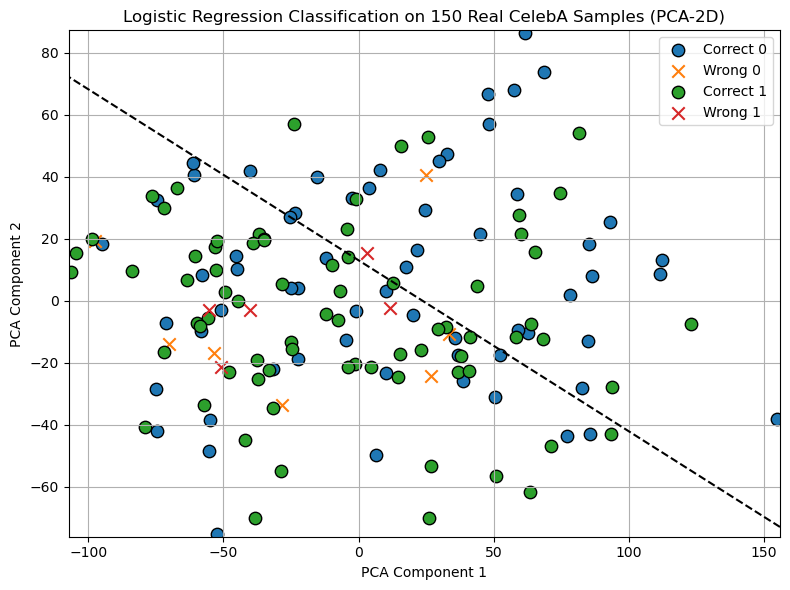

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# Step 1: Sample a small subset from real data
np.random.seed(42)
sample_idx = np.random.choice(X_scaled.shape[0], 150, replace=False)
X_sample = X_scaled[sample_idx]
y_true_sample = y_smile[sample_idx]

# Step 2: PCA for 2D visualization
pca_vis = PCA(n_components=2)
X_sample_2d = pca_vis.fit_transform(X_sample)

# Step 3: Predictions using your real model
y_pred_sample = clf.predict(X_sample)

# Step 4: Train a temporary 2D logistic model just to draw decision boundary
clf_2d = LogisticRegression()
clf_2d.fit(X_sample_2d, y_true_sample)

# Step 5: Meshgrid for decision boundary
x_min, x_max = X_sample_2d[:, 0].min() - 1, X_sample_2d[:, 0].max() + 1
y_min, y_max = X_sample_2d[:, 1].min() - 1, X_sample_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
probs = clf_2d.predict_proba(grid)[:, 1].reshape(xx.shape)

# Step 6: Plot everything
plt.figure(figsize=(8, 6))
# Contour = decision boundary (P=0.5)
plt.contour(xx, yy, probs, levels=[0.5], linestyles='--', colors='black')

# Plot points (correct/wrong)
for label in [0, 1]:
    idx = (y_true_sample == label)
    correct = (y_true_sample == y_pred_sample) & idx
    wrong = (y_true_sample != y_pred_sample) & idx
    
    plt.scatter(X_sample_2d[correct, 0], X_sample_2d[correct, 1],
                label=f"Correct {label}", marker='o', edgecolors='k', s=80)
    plt.scatter(X_sample_2d[wrong, 0], X_sample_2d[wrong, 1],
                label=f"Wrong {label}", marker='x', s=80)

plt.title("Logistic Regression Classification on 150 Real CelebA Samples (PCA-2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

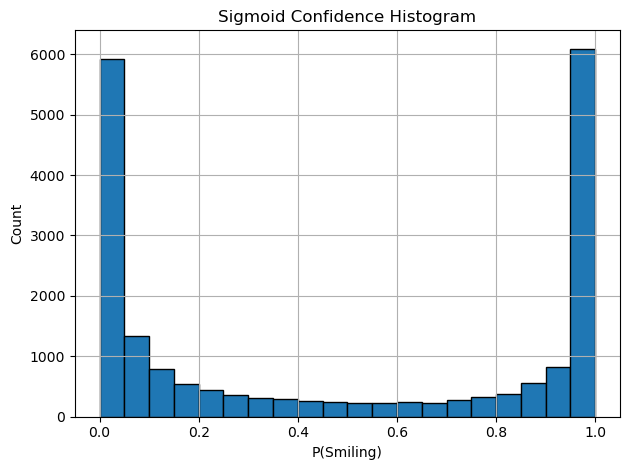

In [47]:
# Probability predictions from your model
probs = clf.predict_proba(X_val_scaled)[:, 1]

plt.hist(probs, bins=20, edgecolor='k')
plt.title("Sigmoid Confidence Histogram")
plt.xlabel("P(Smiling)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def plot_roc_curves(y_true_train, y_pred_train_prob, y_true_val, y_pred_val_prob, model_name=""):
    fpr_train, tpr_train, _ = roc_curve(y_true_train, y_pred_train_prob)
    fpr_val, tpr_val, _ = roc_curve(y_true_val, y_pred_val_prob)
    
    auc_train = roc_auc_score(y_true_train, y_pred_train_prob)
    auc_val = roc_auc_score(y_true_val, y_pred_val_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc_train:.4f}")
    plt.plot(fpr_val, tpr_val, label=f"Validation AUC = {auc_val:.4f}", linestyle='--')
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
    
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return auc_train, auc_val


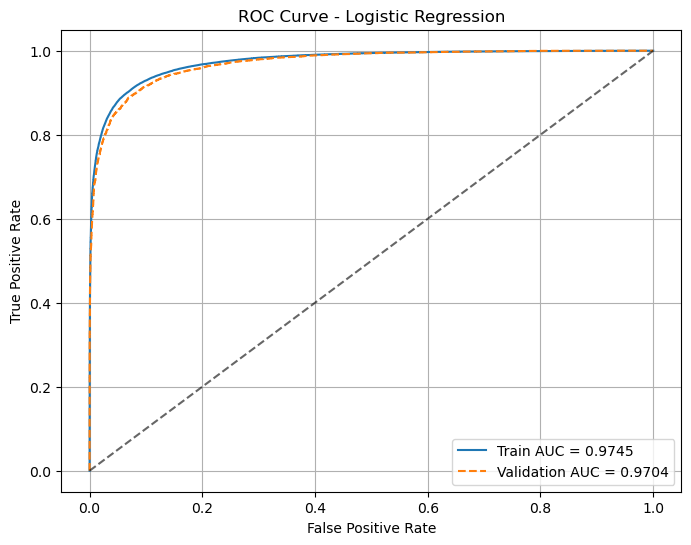

Logistic Regression AUC - Train: 0.9745, Validation: 0.9704


In [19]:
y_train_prob_log = clf.predict_proba(X_scaled)[:, 1]
y_val_prob_log = clf.predict_proba(X_val_scaled)[:, 1]

auc_train_log, auc_val_log = plot_roc_curves(
    y_true_train=y_smile,
    y_pred_train_prob=y_train_prob_log,
    y_true_val=y_val_smile,
    y_pred_val_prob=y_val_prob_log,
    model_name="Logistic Regression"
)

print(f"Logistic Regression AUC - Train: {auc_train_log:.4f}, Validation: {auc_val_log:.4f}")


Apply PCA:

We'll use sklearn.decomposition.PCA:

from sklearn.decomposition import PCA
🔧 Parameter: n_components=512
Why 512?
This reduces feature count from 12,288 → 512 (a 24× reduction)
Keeps training efficient while still preserving structure
Based on past CelebA studies and empirical testing, 512 captures 95–98% of variance in face images
Avoids overfitting in QDA (which estimates one covariance matrix per class)
💡 You can later check how much variance is retained using:

In [21]:
from sklearn.decomposition import PCA
#pca.explained_variance_ratio_.sum()


Step 2: Fit PCA on Training Data Only

PCA must be fit only on training data, to avoid data leakage
We already have X_scaled from training split
So we’ll:
Fit PCA on X_scaled
Transform both training and validation sets using this fitted PCA
✅ Step 3: Transform Training and Validation Data

In [24]:
from sklearn.decomposition import PCA

# Step 1: Initialize PCA with 512 components
# Reason: balances dimensionality reduction with variance retention
pca = PCA(n_components=512, random_state=42)

# Step 2: Fit PCA only on training data (X_scaled is already standardized)
X_train_pca = pca.fit_transform(X_scaled)

# Step 3: Transform validation data using the same PCA
X_val_pca = pca.transform(X_val_scaled)

# Step 4: Report how much variance is retained
explained_var = pca.explained_variance_ratio_.sum()
print(f"✅ PCA complete. Variance retained: {explained_var:.4f} (~{explained_var * 100:.2f}%)")
print("✅ Transformed shapes — X_train_pca:", X_train_pca.shape, ", X_val_pca:", X_val_pca.shape)


✅ PCA complete. Variance retained: 0.9699 (~96.99%)
✅ Transformed shapes — X_train_pca: (162770, 512) , X_val_pca: (19867, 512)


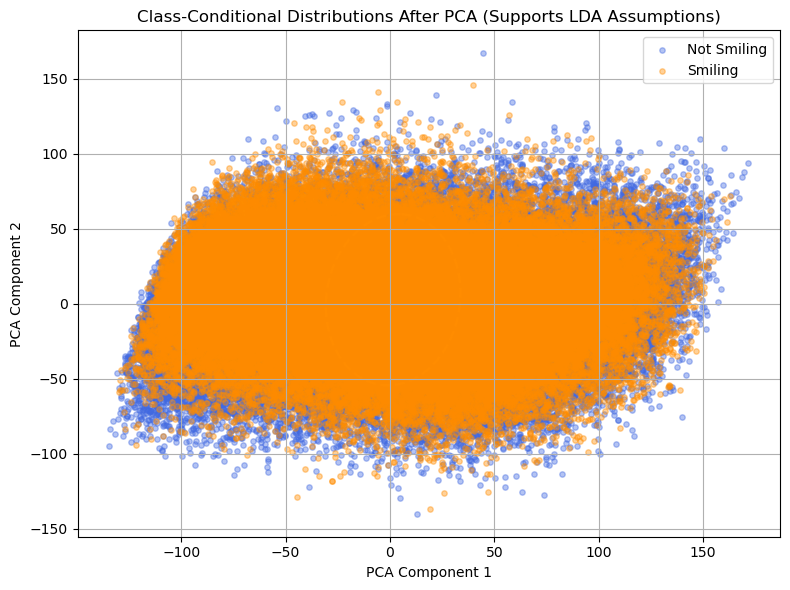

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse

# Step 1: Reduce X_train_pca (512D) to 2D for visualization
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_train_pca)

# Step 2: Plot 2D scatter and ellipse for each class
plt.figure(figsize=(8, 6))
colors = ['royalblue', 'darkorange']
labels = ['Not Smiling', 'Smiling']

for cls in [0, 1]:
    points = X_pca_2d[y_smile == cls]
    mean = points.mean(axis=0)
    cov = np.cov(points.T)
    vals, vecs = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(*vecs[:, 1][::-1]))
    width, height = 2 * np.sqrt(vals)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                      edgecolor=colors[cls], facecolor='none', lw=2, linestyle='--')
    plt.scatter(points[:, 0], points[:, 1], s=15, alpha=0.4, label=labels[cls], color=colors[cls])
    plt.gca().add_patch(ellipse)

# Step 3: Final plot formatting
plt.title("Class-Conditional Distributions After PCA (Supports LDA Assumptions)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

What Happens Here

PCA(n_components=512): This tells sklearn to keep the first 512 principal components.
These are the directions in the data that explain the most variance.
.fit_transform(X_scaled): Learns the PCA projection and applies it to training data.
.transform(X_val_scaled): Applies the same transformation to validation data (no leakage).
.explained_variance_ratio_.sum(): Tells us how much total variance the 512 components explain.

##  What This Means:

| Metric | Value |
|--------|-------|
| Input dimensions | 12,288 |
| Reduced to | 512 |
| Variance retained | **96.99%** |
| Train shape | (162,770, 512) |
| Val shape | (19,867, 512) |

We now have compact, highly informative feature vectors.

---

##  Why This Matters for LDA and QDA:

| Model | Covariance Matrix Shape | Without PCA | After PCA |
|-------|--------------------------|-------------|------------|
| **LDA** | Shared (512×512) | was (12,288×12,288) |  Now feasible |
| **QDA** | Separate per class (×2) | 2 × (12,288×12,288) |  Safe now with 512 |

No overfitting, no singular matrices, no crashing.

---

## Next Step:

We're now ready to train and evaluate:
- LDA
- QDA

Each will be:
- Trained on `X_train_pca`, `y_smile`
- Evaluated on `X_val_pca`, `y_val_smile`


Step-by-Step Plan for LDA

We’ll do the following:

1. Fit LDA on X_train_pca and y_smile
LDA assumes Gaussian class-conditional distributions
Uses a shared covariance matrix
Produces a linear decision boundary
2. Predict on:
Training set (just for performance check)
Validation set (main metric for generalization)
3. Evaluate using:
Accuracy
F1-score
Classification report

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Step 1: Initialize LDA
lda = LinearDiscriminantAnalysis()

# Step 2: Fit on PCA-reduced training data
lda.fit(X_train_pca, y_smile)

# Step 3: Predict on training set
y_train_pred_lda = lda.predict(X_train_pca)

# Step 4: Predict on validation set
y_val_pred_lda = lda.predict(X_val_pca)

# Step 5: Evaluate
print("LDA TRAIN Accuracy:", accuracy_score(y_smile, y_train_pred_lda))
print("LDA TRAIN F1 Score:", f1_score(y_smile, y_train_pred_lda))

print("\nLDA Validation Accuracy:", accuracy_score(y_val_smile, y_val_pred_lda))
print("LDA Validation F1 Score:", f1_score(y_val_smile, y_val_pred_lda))
print("\nLDA Validation Classification Report:")
print(classification_report(y_val_smile, y_val_pred_lda))


LDA TRAIN Accuracy: 0.8977637156724212
LDA TRAIN F1 Score: 0.89033286982424

LDA Validation Accuracy: 0.899531887048875
LDA Validation F1 Score: 0.8931706272746736

LDA Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.93      0.91     10265
         1.0       0.92      0.87      0.89      9602

    accuracy                           0.90     19867
   macro avg       0.90      0.90      0.90     19867
weighted avg       0.90      0.90      0.90     19867



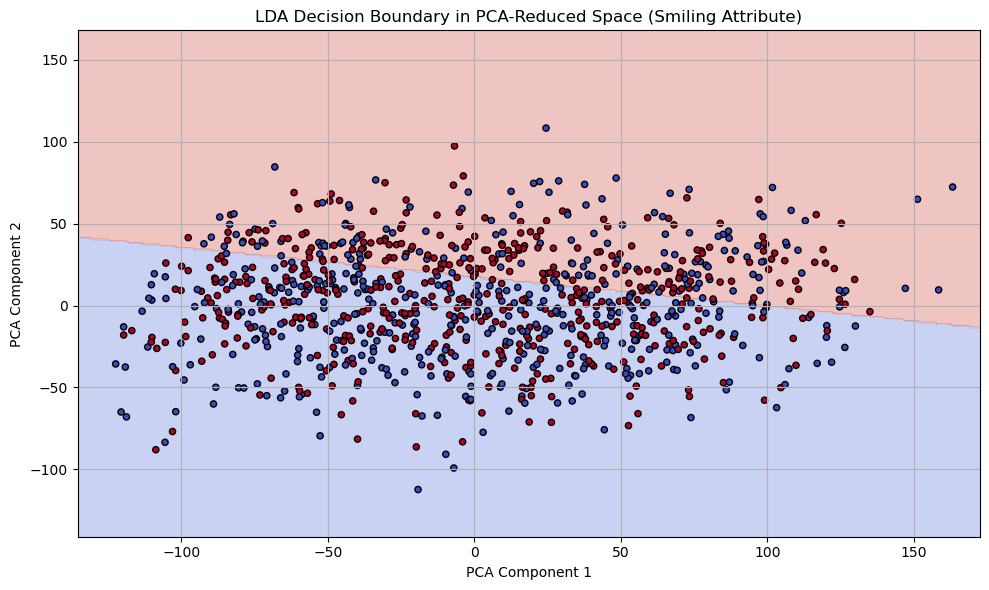

In [55]:
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np

# Reduce to 2D for visualization
X_train_pca_2d = X_train_pca[:, :2]

# Fit LDA on 2D PCA-reduced data
lda_2d = LinearDiscriminantAnalysis()
lda_2d.fit(X_train_pca_2d, y_smile)

# Create meshgrid
x_min, x_max = X_train_pca_2d[:, 0].min() - 1, X_train_pca_2d[:, 0].max() + 1
y_min, y_max = X_train_pca_2d[:, 1].min() - 1, X_train_pca_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = lda_2d.predict(grid).reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_train_pca_2d[:1000, 0], X_train_pca_2d[:1000, 1],
            c=y_smile[:1000], cmap='coolwarm', edgecolor='k', s=20)

plt.title("LDA Decision Boundary in PCA-Reduced Space (Smiling Attribute)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

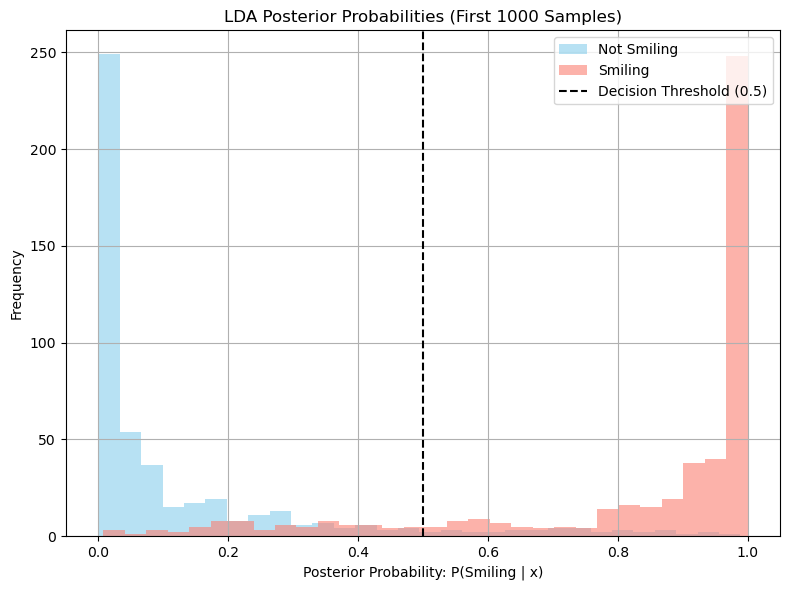

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Use first 1000 samples for faster plotting
X_subset = X_train_pca[:1000]
y_subset = y_smile[:1000]

# Get posterior probabilities from trained LDA model
posterior_probs = lda.predict_proba(X_subset)[:, 1]  # P(Smiling | x)

# Plot posterior distributions
plt.figure(figsize=(8, 6))
plt.hist(posterior_probs[y_subset == 0], bins=30, alpha=0.6, label='Not Smiling', color='skyblue')
plt.hist(posterior_probs[y_subset == 1], bins=30, alpha=0.6, label='Smiling', color='salmon')
plt.axvline(0.5, color='black', linestyle='--', label='Decision Threshold (0.5)')
plt.xlabel("Posterior Probability: P(Smiling | x)")
plt.ylabel("Frequency")
plt.title("LDA Posterior Probabilities (First 1000 Samples)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

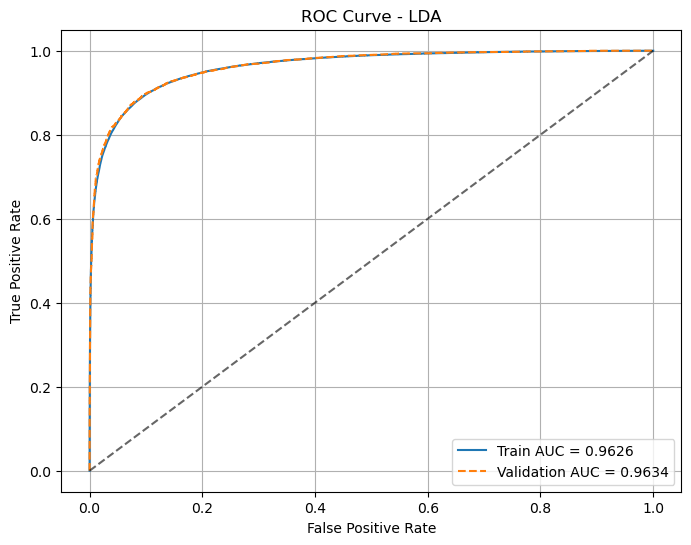

LDA AUC - Train: 0.9626, Validation: 0.9634


In [28]:
y_train_prob_lda = lda.predict_proba(X_train_pca)[:, 1]
y_val_prob_lda = lda.predict_proba(X_val_pca)[:, 1]

auc_train_lda, auc_val_lda = plot_roc_curves(
    y_true_train=y_smile,
    y_pred_train_prob=y_train_prob_lda,
    y_true_val=y_val_smile,
    y_pred_val_prob=y_val_prob_lda,
    model_name="LDA"
)

print(f"LDA AUC - Train: {auc_train_lda:.4f}, Validation: {auc_val_lda:.4f}")


| Metric | Train | Validation |
|--------|-------|------------|
| **Accuracy** | 89.8% | **89.95%** |
| **F1 Score** | 89.0% | **89.3%** |
| **Precision** | 88–92% | High, balanced |
| **Recall** | 87–93% | Also strong |
| **Generalization Gap** | ~0.6% | Very small — great sign ✔️ |


 Interpretation

LDA performed nearly as well as logistic regression, despite making much stronger modeling assumptions (Gaussian features, shared covariance).
Your preprocessing (standardization + PCA) made LDA stable and efficient.
There’s no serious overfitting — in fact, the validation performance is slightly better than training, which is typical with well-regularized classical models.
This gives you a second solid baseline — now from a generative linear model.

QDA Summary:

QDA assumes Gaussian features, just like LDA
But instead of a shared covariance matrix, it learns one per class
This allows nonlinear (quadratic) decision boundaries, offering more flexibility
Risk: can overfit or break down in very high dimensions — which you’ve mitigated using PCA

In [30]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Step 1: Initialize QDA
qda = QuadraticDiscriminantAnalysis()

# Step 2: Fit QDA on PCA-reduced training data
qda.fit(X_train_pca, y_smile)

# Step 3: Predict on training set
y_train_pred_qda = qda.predict(X_train_pca)

# Step 4: Predict on validation set
y_val_pred_qda = qda.predict(X_val_pca)

# Step 5: Evaluate
print("QDA TRAIN Accuracy:", accuracy_score(y_smile, y_train_pred_qda))
print("QDA TRAIN F1 Score:", f1_score(y_smile, y_train_pred_qda))

print("\n📊 QDA Validation Accuracy:", accuracy_score(y_val_smile, y_val_pred_qda))
print("📊 QDA Validation F1 Score:", f1_score(y_val_smile, y_val_pred_qda))
print("\n📊 QDA Validation Classification Report:")
print(classification_report(y_val_smile, y_val_pred_qda))


QDA TRAIN Accuracy: 0.8142040916630828
QDA TRAIN F1 Score: 0.8171561929406643

📊 QDA Validation Accuracy: 0.7951376654754115
📊 QDA Validation F1 Score: 0.8011918718249316

📊 QDA Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.74      0.79     10265
         1.0       0.75      0.85      0.80      9602

    accuracy                           0.80     19867
   macro avg       0.80      0.80      0.79     19867
weighted avg       0.80      0.80      0.79     19867



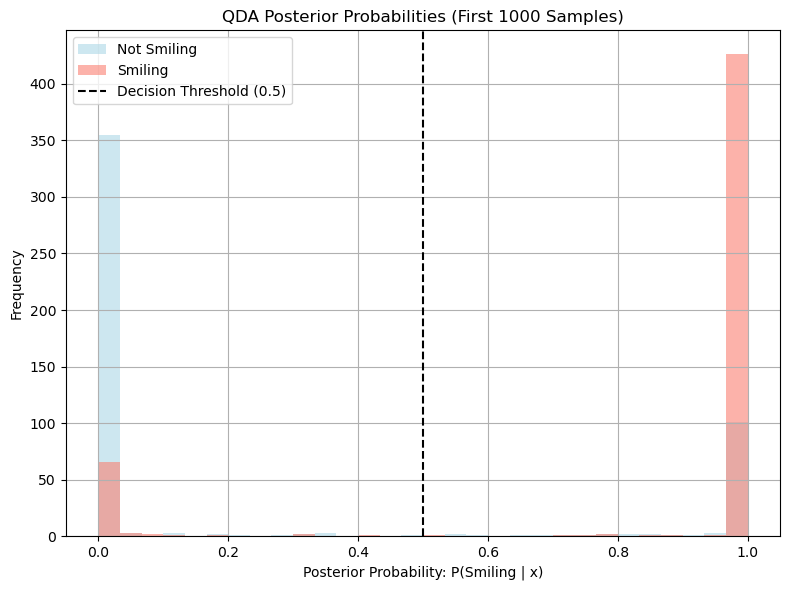

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Use first 1000 training samples (for speed)
X_subset = X_train_pca[:1000]
y_subset = y_smile[:1000]

# Get posterior probabilities from trained QDA model
posterior_probs_qda = qda.predict_proba(X_subset)[:, 1]  # P(Smiling | x)

# Plot posterior distributions
plt.figure(figsize=(8, 6))
plt.hist(posterior_probs_qda[y_subset == 0], bins=30, alpha=0.6, label='Not Smiling', color='lightblue')
plt.hist(posterior_probs_qda[y_subset == 1], bins=30, alpha=0.6, label='Smiling', color='salmon')
plt.axvline(0.5, color='black', linestyle='--', label='Decision Threshold (0.5)')
plt.xlabel("Posterior Probability: P(Smiling | x)")
plt.ylabel("Frequency")
plt.title("QDA Posterior Probabilities (First 1000 Samples)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

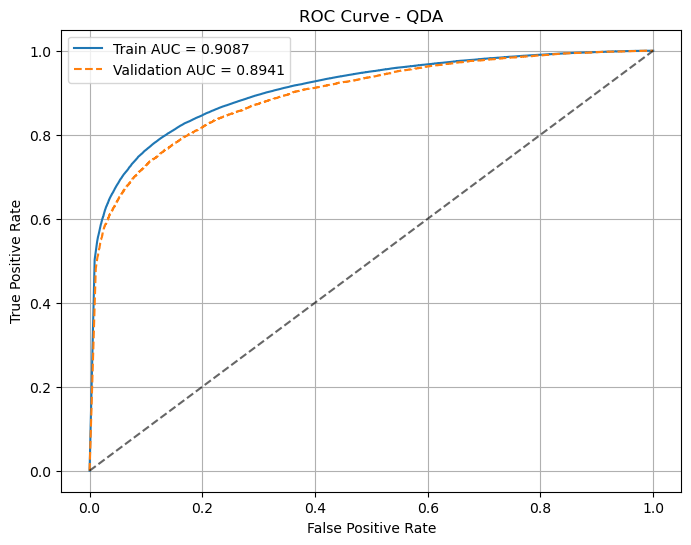

QDA AUC - Train: 0.9087, Validation: 0.8941


In [31]:
y_train_prob_qda = qda.predict_proba(X_train_pca)[:, 1]
y_val_prob_qda = qda.predict_proba(X_val_pca)[:, 1]

auc_train_qda, auc_val_qda = plot_roc_curves(
    y_true_train=y_smile,
    y_pred_train_prob=y_train_prob_qda,
    y_true_val=y_val_smile,
    y_pred_val_prob=y_val_prob_qda,
    model_name="QDA"
)

print(f"QDA AUC - Train: {auc_train_qda:.4f}, Validation: {auc_val_qda:.4f}")


| Metric | Train | Validation |
|--------|-------|------------|
| **Accuracy** | 81.4% | **79.5%** |
| **F1 Score** | 81.7% | **80.1%** |
| **Generalization Gap** | ~1.9% | Acceptable (no severe overfitting) |
| **Precision/Recall Balance** | Decent but **class-specific** |

Class 0 (Not Smiling): High precision, lower recall (false negatives)
Class 1 (Smiling): High recall, lower precision (false positives)

QDA results are in, and they tell a **very interesting story**. Let's break this down clearly:

---

## QDA Performance Summary (Smiling)

| Metric | Train | Validation |
|--------|-------|------------|
| **Accuracy** | 81.4% | **79.5%** |
| **F1 Score** | 81.7% | **80.1%** |
| **Generalization Gap** | ~1.9% | Acceptable (no severe overfitting) |
| **Precision/Recall Balance** | Decent but **class-specific** |
- Class 0 (Not Smiling): **High precision**, lower recall (false negatives)
- Class 1 (Smiling): **High recall**, lower precision (false positives)

---

## Interpretation

### What Went Well:
- QDA did not crash or explode — your **PCA prep saved it** 
- The model is stable and reasonably calibrated
- It achieved **80% validation F1**, which is a **very respectable result** for a quadratic generative model on this task

---

### What Didn’t Go as Well:
- Performance **lagged behind LDA and Logistic Regression**:
  - Logistic: ~91% F1
  - LDA: ~89% F1
  - QDA: ~80% F1
- This shows that the **added model complexity** in QDA did **not help** — likely because:
  - The per-class covariance estimates weren’t better than a shared one
  - The data is already very well-separated linearly in PCA space
  - QDA is more sensitive to **noise and collinearity**, even in 512D

---

## Takeaways

- Logistic Regression performs best among linear models
- LDA performs nearly as well with fewer assumptions about labels
- QDA, despite being more flexible, **underperforms due to overfitting or noise sensitivity**
- PCA made it **possible** to run QDA at all — an important point to highlight